# Анализ вакансий аналитиков HH.ru

# Оглавление
1. [Описание проекта](#cell1)
2. [Предобработка данных](#cell2)
3. [Исследовательский анализ данных](#cell3)
  
   3.1 [Анализ требуемых ключевых навыков](#cell3.1)
   
   3.2 [Анализ вакансий в разбивке по грейдам и регионам](#cell3.2)

   3.3.[Анализ работодателей](#cell3.3)

   3.4 [Анализ вакансий по формату работы и типу занятости](#cell3.4)

   3.5 [Анализ уровня предлагаемой оплаты](#cell3.5)
   
4. [Общий вывод](#cell4)


<a id="cell1"></a> 
## Описание проекта

**Цель проекта:**

выявить различия в предлагаемых вакансиях для аналитиков данных и системных аналитиков, выявить ключевые навыки, требуемые работодателями, описать типовые параметры работодателей  (ТОП-работодателей, зарплата, тип занятости, график работы, в т.ч. в разбивке по грейдам), чтобы помочь потенциальным соискателям сориентироваться на рынке труда.

**Описание данных:**

данные о вакансиях за первое полугодие 2024 г., полученные из API HH.ru

**План исследования:**

1. выполнить предобработку данных (проверить корректность форматов данных, выявить/обработать пропуски, дубликаты, объединить данные)
2. провести исследовательский анализ данных:
   
       - выявить требуемые ключевые навыки кандидатов
       - проанализировать вакансии в разбивке по типу занятости и формату работы, региону
       - определить ТОП работодателей по количеству вакансий
       - определить средние/медианные зарплаты в разбивке по грейдам
       - сформировать типовые портреты соискателей 
        


<a id="cell2"></a> 
## 1 Предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from statistics import mode
from collections import Counter
from ast import literal_eval

In [2]:
# выгрузка данных в датафрейм

data_analyst = pd.read_excel('vacancies_da3.xls')  # вакансии системного аналитика
system_analyst = pd.read_excel('vacancies_sa3.xls')  # вакансии  аналитика данных


In [3]:
# информация о датафрейме
data_analyst.info()
data_analyst.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1801 non-null   int64         
 1   name                              1801 non-null   object        
 2   published_at                      1801 non-null   datetime64[ns]
 3   alternate_url                     1801 non-null   object        
 4   type                              1801 non-null   object        
 5   employer                          1801 non-null   object        
 6   department                        521 non-null    object        
 7   area                              1801 non-null   object        
 8   experience                        1801 non-null   object        
 9   key_skills                        1801 non-null   object        
 10  schedule                          1801 non-null 

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",Полный день,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN
2,100042705,Аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,Открытая,DNS Головной офис,NaN,Владивосток,Junior+ (1-3 years),"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД, BPMN, Clickhouse",NaN,NaN
3,100046788,Ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,Открытая,Х5 Group,"X5 GROUP, Центральный офис",Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",Полный день,Полная занятость,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,NaN,NaN,ЗП не указана,"MS Office, SQL, Python, Hadoop, Нive, Аналитич...","Pandas, Юнит-экономика",Коммуникация
4,100056244,Аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,Открытая,ЛУКОЙЛ,NaN,Москва,Middle (3-6 years),['Документация'],Полный день,Полная занятость,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,NaN,NaN,ЗП не указана,NaN,NaN,Документация


In [4]:
# информация о датафрейме
system_analyst.info()
system_analyst.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1915 non-null   int64         
 1   name                              1915 non-null   object        
 2   published_at                      1915 non-null   datetime64[ns]
 3   alternate_url                     1915 non-null   object        
 4   type                              1915 non-null   object        
 5   employer                          1915 non-null   object        
 6   department                        361 non-null    object        
 7   area                              1915 non-null   object        
 8   experience                        1915 non-null   object        
 9   key_skills                        1915 non-null   object        
 10  schedule                          1915 non-null 

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100046399,Системный аналитик,2024-07-08 10:22:57,https://hh.ru/vacancy/100046399,Открытая,Юрент,NaN,Москва,Middle (3-6 years),"['1С', 'Аналитический склад ума', 'confluence'...",Полный день,Полная занятость,юрент — это новый уровень городской мобильност...,юрент новый уровень городской мобильность круп...,NaN,NaN,ЗП не указана,"SQL, Аналитический склад ума, 1С",confluence,NaN
1,100050107,Бизнес/Системный Аналитик,2024-07-06 17:19:32,https://hh.ru/vacancy/100050107,Открытая,Surf,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",Удаленная работа,Полная занятость,в surf уже 13 лет мы разрабатываем много разны...,surf 13 год разрабатывать разный продукт начин...,NaN,NaN,ЗП не указана,"BPMN, UML, Английский язык, Системный анализ, ...",NaN,Документация
2,100059559,Системный IT аналитик,2024-07-08 11:48:17,https://hh.ru/vacancy/100059559,Открытая,AMarkets,NaN,Москва,Junior+ (1-3 years),['Документация'],Полный день,Полная занятость,"мы - международная fintech компания amarkets, ...",международный fintech компания amarkets 2 7 го...,233750.0,NaN,ЗП не указана,NaN,NaN,Документация
3,100063260,Системный Аналитик ERP-решений,2024-07-09 10:51:54,https://hh.ru/vacancy/100063260,Открытая,Астор,NaN,Москва,Senior (6+ years),"['ERP', 'Atlassian Jira', '1С: Управление Прои...",Удаленная работа,Полная занятость,компания «астор» с 2000 года занимается разраб...,компания астор 2 год заниматься разработка вне...,NaN,NaN,ЗП не указана,"ERP, 1С: Управление Торговлей, Atlassian Jira,...",confluence,Коммуникация
4,100064793,Системный аналитик,2024-07-08 16:39:40,https://hh.ru/vacancy/100064793,Открытая,Зетта Страхование,NaN,Москва,Junior+ (1-3 years),"['JSON', 'SQL', 'XML', 'SOAP', 'HTML', 'JS', '...",Полный день,Полная занятость,обязанности: анализ задач развития и сопрово...,обязанность анализ задача развитие сопровожден...,NaN,NaN,ЗП не указана,"SQL, C#, Java, JS, SOAP, JSON, XML, HTML, CSS",NaN,NaN


In [5]:
# объединяем данные в один датасет
data_analyst['profession_type'] = 'data_analyst'
system_analyst['profession_type'] = 'system_analyst'
hh_data = pd.concat([data_analyst, system_analyst], ignore_index=True)
hh_data.info()
hh_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3716 non-null   int64         
 1   name                              3716 non-null   object        
 2   published_at                      3716 non-null   datetime64[ns]
 3   alternate_url                     3716 non-null   object        
 4   type                              3716 non-null   object        
 5   employer                          3716 non-null   object        
 6   department                        882 non-null    object        
 7   area                              3716 non-null   object        
 8   experience                        3716 non-null   object        
 9   key_skills                        3716 non-null   object        
 10  schedule                          3716 non-null 

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,profession_type
3138,52410283,Системный аналитик 1С,2024-07-08 13:56:18,https://hh.ru/vacancy/52410283,Открытая,Диалог Информационные Технологии,NaN,Екатеринбург,Junior+ (1-3 years),"['Бизнес-анализ', 'Моделирование бизнес процес...",...,Полная занятость,«диалог ит» — российская аккредитованная it-ко...,диалог ита российский аккредитовать it компани...,NaN,NaN,ЗП не указана,"1С: Предприятие 8, Моделирование бизнес процес...",NaN,Документация,system_analyst
2224,102459625,Системный аналитик / Project manager (удаленно),2024-07-06 20:56:51,https://hh.ru/vacancy/102459625,Открытая,Андреев Артём Александрович,NaN,Москва,Middle (3-6 years),['Документация'],...,Полная занятость,"бьюти бот - это инновационный ит-продукт, what...",бьютя бот инновационный ита продукт whatsapp б...,NaN,NaN,ЗП не указана,NaN,NaN,Документация,system_analyst
30,100261906,Аналитик данных (Python),2024-05-27 01:56:59,https://hh.ru/vacancy/100261906,Открытая,Центральный банк Российской Федерации,NaN,Москва,Junior+ (1-3 years),"['SQL-запросы', 'JIRA', 'Python']",...,Полная занятость,задачи: анализ требований структурных подразд...,задача анализ требование структурный подраздел...,NaN,NaN,ЗП не указана,"JIRA, Python, SQL-запросы",NaN,NaN,data_analyst
2962,103471811,Системный аналитик (мобильные приложения),2024-07-08 09:07:41,https://hh.ru/vacancy/103471811,Открытая,РНКБ Банк (ПАО),NaN,Москва,Senior (6+ years),"['iOS', 'Мобильные приложения', 'Разработка те...",...,Полная занятость,рнкб – ключевой банк республики крым. также пр...,рнкб ключевой банк республика крым также предс...,NaN,NaN,ЗП не указана,"BPMN, Разработка технических заданий, Системны...",confluence,Документация,system_analyst
1460,98428661,Аналитик данных,2024-05-06 07:58:55,https://hh.ru/vacancy/98428661,Открытая,Медикал Скул,NaN,Москва,Junior (no experince),['Аналитическое мышление'],...,Полная занятость,md.school — это онлайн-университет доказательн...,md school онлайн университет доказательный мед...,NaN,NaN,ЗП не указана,NaN,NaN,Аналитическое мышление,data_analyst


In [6]:
# количество пропусков
hh_data.isna().sum()

id                                     0
name                                   0
published_at                           0
alternate_url                          0
type                                   0
employer                               0
department                          2834
area                                   0
experience                             0
key_skills                             0
schedule                               0
employment                             0
description                            0
description_lemmatized                 0
salary_from                         3012
salary_to                           3209
salary_bin                             0
key_skills_from_key_skills_field    1349
hard_skills_from_description        2728
soft_skills_from_description        1701
profession_type                        0
dtype: int64

In [7]:
#проверяем значения ключевых столбцов, в т.ч. на наличие неявных дубликатов
print(hh_data['type'].unique())
print(hh_data['area'].unique())
print(hh_data['experience'].unique())
print(hh_data['schedule'].unique())
print(hh_data['employment'].unique())
print(hh_data['profession_type'].unique())

['Открытая']
['Владивосток' 'Москва' 'Санкт-Петербург' 'Казань' 'Екатеринбург'
 'Смоленск' 'Новосибирск' 'Омск' 'Краснодар' 'Самара' 'Уфа' 'Нефтекамск'
 'Курган' 'Пермь' 'Ростов-на-Дону' 'Нижний Новгород' 'Чебоксары'
 'Владимир' 'Воронеж' 'Адыгейск' 'Тверь' 'Балашиха'
 'Киров (Кировская область)' 'Калининград' 'Тюмень' 'Челябинск' 'Майкоп'
 'Липецк' 'Красноярск' 'Горно-Алтайск' 'Дзержинский' 'Белгород' 'Ступино'
 'Рязань' 'Томск' 'Северск (Томская область)' 'Артем' 'Верхняя Пышма'
 'Щербинка' 'Кемерово' 'Подольск (Московская область)' 'Королев' 'Ижевск'
 'Вейделевка' 'Химки' 'Ульяновск' 'Иваново (Ивановская область)'
 'Луховицы' 'Златоуст' 'Набережные Челны' 'Байбек' 'Иркутск' 'Турочак'
 'Симферополь' 'Вельск' 'Алтайское' 'Сочи' 'Саратов' 'Оренбург' 'Псков'
 'Великие Луки' 'Магнитогорск' 'Пушкино (Московская область)' 'Мытищи'
 'Тула' 'Тольятти' 'Волгоград' 'Дмитров' 'Якутск' 'Одинцово' 'Апатиты'
 'Курск' 'Геленджик' 'Рубцовск' 'Кольчугино' 'Калуга' 'Кострома' 'Пенза'
 'Ставрополь' 'Ха

<div style="border:solid green 1px; padding: 10px">
Вывод: 

- форматы данных корректны, соответствуют полям.
- имеется большое количество пропусков в полях: department, salary_from, salary_to,  key_skills_from_key_skills_field. Пропуски будут при необходимости обработаны на следующих этапах. На данном этапе остаются без изменений.
- нет дубликатов, в т.ч. неявных в ключевых полях, поля корректно заполнены 

<a id="cell3"></a> 
## Исследовательский анализ данных


<a id="cell3.1"></a> 
### Анализ требуемых ключевых навыков 

Определим наиболее востребованные ключевые навыки для кандидатов обоих типов вакансий (дата-аналитик и системный аналитик)

In [8]:
# проверяем значения поля key_skills 
hh_data[['key_skills']].values

array([["['Power BI', 'СУБД', 'Python', 'SQL']"],
       ["['MS SQL', 'Работа с базами данных', 'MS Excel']"],
       ["['SQL', 'Power BI', 'СУБД', 'Python', 'Clickhouse', 'BPMN']"],
       ...,
       ['[]'],
       ["['SOA', 'XML', 'Atlassian Jira', 'Use cases', 'DB2', 'BPMN', 'API', 'Базы данных', 'JSON', 'IDEF', 'ORACLE', 'REST', 'SOAP', 'UML', 'WSDL', 'Xsd', 'SQL', 'System Analysis', 'User Story', 'NoSQL', 'confluence', 'Agile Project Management', 'PostgreSQL', 'Системный анализ']"],
       ["['Документация', '1С: Предприятие', '1С: Бит Финанс', 'MS Project', 'MS Excel']"]],
      dtype=object)

В поле key_skills много лишних символов, следует очистить данные перед дальнейшей обработкой

In [9]:
# из данных в key_skills удалим скобки и лишние кавычки, приведем к нижнему регистру и разделим по запятым, чтобы строку превратить в список
hh_data['key_skills'] = hh_data['key_skills'].str.replace("\[|\]|\'",'', regex=True).str.lower().str.split(',')
hh_data['key_skills']

0                        [power bi,  субд,  python,  sql]
1            [ms sql,  работа с базами данных,  ms excel]
2       [sql,  power bi,  субд,  python,  clickhouse, ...
3       [анализ данных,  коммуникация,  sql,  ms offic...
4                                          [документация]
                              ...                        
3711                        [документация,  коммуникация]
3712    [idef,  разработка технических заданий,  rest,...
3713                                                   []
3714    [soa,  xml,  atlassian jira,  use cases,  db2,...
3715    [документация,  1с: предприятие,  1с: бит фина...
Name: key_skills, Length: 3716, dtype: object

In [10]:
# создадим новую строку для каждого элемента списка в столбце
hh_data['key_skills'].explode().str.strip()

0              power bi
0                  субд
0                python
0                   sql
1                ms sql
             ...       
3715       документация
3715    1с: предприятие
3715     1с: бит финанс
3715         ms project
3715           ms excel
Name: key_skills, Length: 20568, dtype: object

In [11]:
# испольуем Counter, чтобы посчитать частоту навыков 
skills = Counter(hh_data['key_skills'].explode().str.strip().sort_values())
skills

Counter({'документация': 1571,
         'sql': 1438,
         'confluence': 699,
         'аналитическое мышление': 658,
         'bpmn': 656,
         'python': 629,
         'системный анализ': 576,
         'uml': 574,
         '': 512,
         'анализ данных': 487,
         'коммуникация': 461,
         'rest': 394,
         'pandas': 330,
         'работа с базами данных': 267,
         'soap': 266,
         'аналитика': 264,
         'разработка технических заданий': 253,
         'работа с большим объемом информации': 233,
         'power bi': 231,
         'бизнес-анализ': 227,
         'ms excel': 226,
         'постановка задач разработчикам': 216,
         'базы данных': 215,
         'ms sql': 212,
         'xml': 212,
         'api': 192,
         'postgresql': 181,
         'atlassian jira': 159,
         'json': 152,
         'atlassian confluence': 138,
         'data analysis': 131,
         'сбор и анализ информации': 128,
         'аналитические исследования': 123,


In [12]:
# разделим наиболее популярные навыки (которые встречались не менее 10 раз) на hard и soft
soft_skills = {'аналитическое мышление': 658,
               'коммуникация': 461,
               'работа с большим объемом информации': 233,
               'переговоры': 54,
               'прогнозирование': 54,
               'работа в команде': 53,
               'деловая коммуникация': 48,
               'аналитический склад ума': 46,
               'системное мышление': 45,
               'аналитические способности': 26,
               'креативность': 26,
               'системный подход': 24,
               'организаторские навыки': 22,
               'обучение и развитие': 21,
               'ответственность': 20,
               'грамотная речь': 18,
               'деловая переписка': 15,
               'навыки презентации': 13,
               'критическое мышление': 10,
               'навыки составления отчетности': 10,
               'наставничество': 10,
               'точность и внимательность к деталям': 10,
               'умение принимать решения': 10,
               'управление командой': 10
              }
hard_skills = {'документация': 1571,
               'sql': 1438, 
               'confluence': 699,
               'bpmn': 656,
               'python': 629,
               'системный анализ': 576,
               'uml': 574,
               'анализ данных': 487, 
               'rest': 394, 
               'pandas': 330,
               'работа с базами данных': 267, 
               'soap': 266,
               'аналитика': 264,
               'разработка технических заданий': 253,
               'power bi': 231,
               'бизнес-анализ': 227,
               'ms excel': 226,
               'постановка задач разработчикам': 216,
               'базы данных': 215,
               'ms sql': 212,
               'xml': 212,
               'api': 192,
               'postgresql': 181,
               'atlassian jira': 159,
               'json': 152,
               'atlassian confluence': 138,
               'data analysis': 131,
               'сбор и анализ информации': 128,
               'аналитические исследования': 123,
               'json api': 119,
               'математическая статистика': 111,'kafka': 97,
               'tableau': 95,
               'моделирование бизнес процессов': 91,
               'rest api': 87,
               'scrum': 86,
               'dwh': 84,
               'etl': 78,
               'английский язык': 77,
               'анализ бизнес показателей': 75,
               'оптимизация бизнес-процессов': 74,
               'статистический анализ': 72,
               'системная интеграция': 69,
               'ms powerpoint': 67,
               'agile': 65,
               'техническая документация': 65,
               'big data': 63,
               'a/b тесты': 60,
               'git': 56,
               'xsd': 56,
               'субд': 56,
               'юнит-экономика': 52,
               'hadoop': 50,
               'сводные таблицы': 50,
               'oracle': 49,
               'postman': 49,
               'clickhouse': 47,
               'rabbitmq': 46,
               'agile project management': 44,
               'ms visio': 43,
               'математический анализ': 42,
               'анализ требований': 41,
               'erp-системы на базе 1с': 40,
               'подготовка презентаций': 40,
               'airflow': 39,
               'ms power bi': 37,
               'swagger': 36,
               'system analysis': 33,
               'vba': 33,
               'информационные технологии': 33,
               'apache kafka': 32,
               'bi': 32,
               'spark': 32,
               'анализ рынка': 32,
               'управление проектами': 32,
               'автоматизация процессов': 31,
               'проектная документация': 31,
               'тестирование': 31,
               'numpy': 30,
               'java': 29,
               '1с': 28,
               'greenplum': 28,
               'http': 28,
               'jira': 28,
               'power query': 28,
               'powerbi': 28,
               'user story': 28,
               'business analysis': 27,
               'визуализация данных': 27,
               'разработка по': 27,
               'excel': 26,
               '1с: предприятие 8': 25,
               'сбор требований': 25,
               '1с: управление торговлей': 24,
               'подготовка отчетов': 24,
               '1с: предприятие': 22,
               'linux': 22,
               'use case analysis': 22,
               'описание бизнес-процессов': 22,
               'machine learning': 20,
               'dax': 19,
               '1с: зарплата и управление персоналом': 18,
               'data science': 18,
               'javascript': 18,
               'mysql': 18,
               'маркетинговый анализ': 18,
               'idef': 17,
               'ml': 17,
               'разработка инструкций': 17,
               'разработка проектной документации': 17,
               '1с программирование': 16,
               'google analytics': 16,
               'oracle pl/sql': 16,
               'superset': 16,
               'экономический анализ': 16,
               '1с: документооборот': 15,
               'html': 15,
               'mq': 15,
               'nosql': 15,
               'r': 15,
               'анализ бизнес-процессов': 15,
               'математическое моделирование': 15,
               '1с: управление производственным предприятием': 14,
               'figma': 14,
               'аналитика продаж': 14,
               'микросервисная архитектура': 14,
               'crm': 13,
               'docker': 13,
               'grafana': 13,
               'power pivot': 13,
               'pytorch': 13,
               'qlik sense': 13,
               'ui': 13,
               'waterfall': 13,
               'бухгалтерский учет': 13,
               'торговая площадка': 13,
               'управленческая отчетность': 13,
               'финансовый анализ': 13,
               'datalens': 12,
               'draw.io': 12,
               'kanban': 12,
               'написание тз': 12,
               'работа с системами аналитики': 12,
               'складская логистика': 12,
               'ad hoc analysis': 11,
               'erp': 11,
               'hive': 11,
               'mongodb': 11,
               'ms office': 11,
               'openapi': 11,
               'teradata': 11,
               'use cases': 11,
               'wms': 11,
               'витрины данных': 11,
               'впр': 11,
               'документирование бизнес-требований': 11,
               'управление требованиями': 11,
               'camunda': 10,
               'erd': 10,
               'google docs': 10,
               'soa': 10,
               'ui/ux': 10,
               'web аналитика': 10,
               'wsdl': 10,
               'анализ рисков': 10,
               'аналитика данных': 10,
               'интеграции': 10,
               'оптимизация бизнес процессов': 10,
               'пользователь пк': 10,
               'проектирование баз данных': 10                 
              }

In [13]:
# доролнительно сформируем список наиболее популярных навыков, которые встерчались не менее 10 раз 
popular_skills = [key for key, value in skills.items() if value >= 10]
print(popular_skills)    

['', '1с', '1с программирование', '1с: документооборот', '1с: зарплата и управление персоналом', '1с: предприятие', '1с: предприятие 8', '1с: управление производственным предприятием', '1с: управление торговлей', 'a/b тесты', 'ad hoc analysis', 'agile', 'agile project management', 'airflow', 'apache kafka', 'api', 'atlassian confluence', 'atlassian jira', 'bi', 'big data', 'bpmn', 'business analysis', 'camunda', 'clickhouse', 'confluence', 'crm', 'data analysis', 'data science', 'datalens', 'dax', 'docker', 'draw.io', 'dwh', 'erd', 'erp', 'erp-системы на базе 1с', 'etl', 'excel', 'figma', 'git', 'google analytics', 'google docs', 'grafana', 'greenplum', 'hadoop', 'hive', 'html', 'http', 'idef', 'java', 'javascript', 'jira', 'json', 'json api', 'kafka', 'kanban', 'linux', 'machine learning', 'ml', 'mongodb', 'mq', 'ms excel', 'ms office', 'ms power bi', 'ms powerpoint', 'ms sql', 'ms visio', 'mysql', 'nosql', 'numpy', 'openapi', 'oracle', 'oracle pl/sql', 'pandas', 'postgresql', 'postma

In [14]:
# функция, чтобы создать поля с hard и soft навыками исходя из заранее подготовленных списков навыков и навыков в key_skills
def get_skills(x, skills):
    hard = []
    for skill in x:
        if skill.strip() in skills:
            hard += [skill.strip()]
    return hard

hh_data['hard_skills'] = hh_data['key_skills'].apply(lambda x: get_skills(x, hard_skills))
hh_data['soft_skills'] = hh_data['key_skills'].apply(lambda x: get_skills(x, soft_skills))
hh_data[['key_skills','hard_skills_from_description','soft_skills_from_description','hard_skills','soft_skills']]

,key_skills,hard_skills_from_description,soft_skills_from_description,hard_skills,soft_skills
0,"[power bi, субд, python, sql]",NaN,NaN,"[power bi, субд, python, sql]",[]
1,"[ms sql, работа с базами данных, ms excel]",NaN,NaN,"[ms sql, работа с базами данных, ms excel]",[]
2,"[sql, power bi, субд, python, clickhouse, ...",NaN,NaN,"[sql, power bi, субд, python, clickhouse, bpmn]",[]
3,"[анализ данных, коммуникация, sql, ms offic...","Pandas, Юнит-экономика",Коммуникация,"[анализ данных, sql, ms office, python, аналит...","[коммуникация, управление командой, работа с б..."
4,[документация],NaN,Документация,[документация],[]
...,...,...,...,...,...
3711,"[документация, коммуникация]",NaN,"Коммуникация, Документация",[документация],[коммуникация]
3712,"[idef, разработка технических заданий, rest,...",NaN,Документация,"[idef, разработка технических заданий, rest, б...",[]
3713,[],NaN,NaN,[],[]
3714,"[soa, xml, atlassian jira, use cases, db2,...",confluence,NaN,"[soa, xml, atlassian jira, use cases, bpmn, ap...",[]


In [15]:
# cформируем таблицы с навыками в зависимости от грейда и типа вакансий
hard_skills = hh_data[['profession_type', 'experience','hard_skills']].explode('hard_skills').\
        groupby(['profession_type','experience','hard_skills']).size().rename('hard_skill_cnt').reset_index()

soft_skills = hh_data[['profession_type', 'experience','soft_skills']].explode('soft_skills').\
        groupby(['profession_type','experience','soft_skills']).size().rename('soft_skill_cnt').reset_index()


In [16]:
# посмотрим ТОП-5 soft и hard навыков для каждого грейда
result_hard = hard_skills.groupby(['profession_type','experience']).apply(lambda x: x.nlargest(5, 'hard_skill_cnt')).reset_index(drop=True)
result_soft = soft_skills.groupby(['profession_type','experience']).apply(lambda x: x.nlargest(5, 'soft_skill_cnt')).reset_index(drop=True)


display(result_hard)
display(result_soft)

,profession_type,experience,hard_skills,hard_skill_cnt
0,data_analyst,Junior (no experince),sql,37
1,data_analyst,Junior (no experince),python,34
2,data_analyst,Junior (no experince),анализ данных,31
3,data_analyst,Junior (no experince),ms excel,28
4,data_analyst,Junior (no experince),pandas,21
5,data_analyst,Junior+ (1-3 years),sql,469
6,data_analyst,Junior+ (1-3 years),python,321
7,data_analyst,Junior+ (1-3 years),анализ данных,262
8,data_analyst,Junior+ (1-3 years),pandas,186
9,data_analyst,Junior+ (1-3 years),документация,150


,profession_type,experience,soft_skills,soft_skill_cnt
0,data_analyst,Junior (no experince),аналитическое мышление,40
1,data_analyst,Junior (no experince),работа с большим объемом информации,19
2,data_analyst,Junior (no experince),коммуникация,17
3,data_analyst,Junior (no experince),работа в команде,6
4,data_analyst,Junior (no experince),креативность,4
5,data_analyst,Junior+ (1-3 years),аналитическое мышление,241
6,data_analyst,Junior+ (1-3 years),работа с большим объемом информации,119
7,data_analyst,Junior+ (1-3 years),коммуникация,105
8,data_analyst,Junior+ (1-3 years),прогнозирование,26
9,data_analyst,Junior+ (1-3 years),деловая коммуникация,19


<div style="border:solid green 1px; padding: 10px">
Вывод: 
hard-навыки почти одинаковы для всех грейдов

наиболее востребованные hard-навыки для дата аналитиков:
    sql, python, pandas, анализ данных, документация
    
наиболее востребованные hard-навыки для системных аналитиков:
    документация, bpmn, sql, confluence, системный анализ		

soft-навыки идентичны для обоих типов специальностей (дата и системный аналитик) и также  почти одинаковы для всех грейдов. 
Наиболее востребованные soft-навыки: аналитическое мышление, работа с большим объемом информации, коммуникация

In [17]:
# найдем средний процент hard навыков от всех навыков
hh_data['hard_skills_cnt'] = hh_data['hard_skills'].apply(len)
hh_data['soft_skills_cnt'] = hh_data['soft_skills'].apply(len)
hh_data['all_skills_cnt'] = hh_data['hard_skills_cnt'] + hh_data['soft_skills_cnt']
round((hh_data['hard_skills_cnt'] / hh_data['all_skills_cnt']).mean() * 100, 2)

86.31

<div style="border:solid green 1px; padding: 10px">
Вывод: большую часть требований (более 85%) составляют hard навыки, т.о. специальности дата и системного аналитика требуют больше технических компетенций, чем soft навыков, особенно на начальных и средних позициях.  

<a id="cell3.2"></a> 
### Анализ вакансий в разбивке по грейдам и регионам

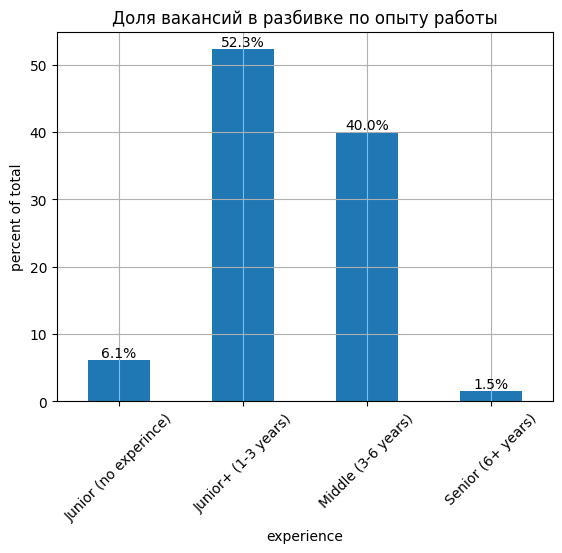

In [18]:
# подсчет количества и доли вакансий в разбивке по опыту работы
hh_count = hh_data['id'].count() # подсчет общего количества всех вакансий

experience = hh_data.groupby('experience').agg(
        count_vacancies=('id', 'count'),  
        percentage=('id', lambda x: x.count() / hh_count * 100)  
    ).reset_index()

# визуализируем доли на диаграмме 
ax = experience.plot(
    kind='bar',x='experience', y='percentage', 
    ylabel = 'percent of total', 
    title ='Доля вакансий в разбивке по опыту работы',
    legend = False, 
    grid=True)
plt.xticks(rotation=45)

# Добавляем метки значений
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + height
    
    # Отображаем процентное значение с округлением до 1 знака после запятой
    ax.annotate(f'{height:.1f}%', 
                (x, y), 
                ha='center', 
                va='bottom', 
                fontsize=10)
plt.show()

In [19]:
# подсчет количества вакансий в разбивке по опыту работы и городу
(hh_data.pivot_table(
    index='area',
    columns=['profession_type','experience'],
    values='name',
    aggfunc='count',
    margins=True
).sort_values('All', ascending=False)).round(0).head(16).fillna(0).astype(int)\
.style.background_gradient(axis=None)



<div style="border:solid green 1px; padding: 10px">
Вывод:

- наиболее востребованы специалисты c опытом работы: уровня Junior+ и Middle. При этом  у дата-аналитиков более востребованы специалисты Junior+, а в вакансиях системного аналитика более востребованы специалисты Middle.  Начинающим дата-аналитикам будет проще найти вакансию.
- Москва с существенным отрывом лидирует по числу размещенных вакансий обоих типов (почти 65% всех размещенных вакансий), на втором месте - СПб (примерно 10% всех вакансий), в ТОП-5 также входят другие города-миллионники (Екатеринбург, Новосибирск, Казань, Н.Новгород), на эти 4 города в совокупности приходится порядка 9% вакансий. 
- Специалисты без опыта мало востребованы на рынке труда (6% всех размещенных вакансий)
- Следует отметить очень низкое предложение вакансий обоих типов для Senior специалистов (1.5% всех размещенных вакансий). Возможно, это связано с тем, что  HH.ru  - площадка, более ориентированная на специалистов массовых сегментов, а Senior специалисты используют другие более узко специализированные площадки

Дополнительно проанализируем какие работодатели готовы нанимать специалистов без опыта

In [20]:
# фильтруем данные по опыту, затем сводим в таблицу, подсчитываем количество вакансий
hh_data.loc[hh_data['experience']=='Junior (no experince)'].pivot_table(
    index='employer',
    columns=['profession_type','experience'],
    values='name',
    aggfunc='count',
    margins=True
).sort_values('All', ascending=False).head(16).fillna(0).query('employer!= "All"').astype(int)\
.style.background_gradient(axis=None)

profession_type,data_analyst,system_analyst,All
experience,Junior (no experince),Junior (no experince),
employer,,,
Aston,0,16,16
СБЕР,13,2,15
Компания Апогей (1С-франчайзи),0,8,8
"МАГНИТ, Розничная сеть",7,0,7
Центр финансовых технологий,2,3,5
TWIGA Communication Group,0,5,5
Дунайс,0,4,4
"Согласие, страховая компания",4,0,4


<div style="border:solid green 1px; padding: 10px">
Вывод: вакансии для специалистов без опыта в основном размещают специализированные ИТ-компании и крупные технологические компании (бигтех)

<a id="cell3.3"></a> 
### Анализ работодателей

Посмотрим ТОП крупнейших работодателей по количеству вакансий 

In [21]:
# подсчет количества вакансий в разбивке по опыту работы и работодателю
hh_data.pivot_table(
    index='employer',
    columns=['profession_type','experience'],
    values='name',
    aggfunc='count',
    margins=True
).sort_values('All', ascending=False).head(16).fillna(0).query('employer != "All"').astype(int)\
.style.background_gradient(axis=None)

<div style="border:solid green 1px; padding: 10px">
Вывод:  ТОП-15 работодателей это компании  следующих отраслей: банки, IT, маркетплейсы, ритейл, коммуникации. Лидером по количеству размещенных вакансий обоих типов является Сбер.


Посчитаем какая доля вакансий размещена компаниями банковского сектора

In [22]:
# выделим работодателей банковского сектора
def f_categorize_employer(row):
    if 'банк' in row or 'Банк' in row or 'СБЕР' in row:
        return 'finance'
    else:
        pass
        
finance_sector = hh_data['employer'].apply(f_categorize_employer).tolist() # применим функцию с полю 'employer'

# считаем количество компаний в категории банковский сектор
finance_sector_count=[]
for i in finance_sector:
    if i=='finance':
        finance_sector_count.append(i)

print(f'Доля вакансий, размещенная компаниями банковского сектора: {len(finance_sector_count)/len(finance_sector)*100}')  


Доля вакансий, размещенная компаниями банковского сектора: 17.330462863293864


<a id="cell3.4"></a> 
### Анализ вакансий по формату работы и типу занятости

In [23]:
# количество вакансий в разбивке по формату работы
hh_data.pivot_table(
    index='schedule',
    columns=['profession_type','experience'],
    values='name',
    aggfunc='count',
    margins=True
).sort_values('All', ascending=False).fillna(0).query('schedule != "All"').astype(int)\
.style.background_gradient(axis=None)

<div style="border:solid green 1px; padding: 10px">
Вывод: для обоих типов вакансий на всех грейдах лидирует формат - полный день. Почти 17% вакансий дата-аналитиков предлагают удаленную работу , у системных аналитиков удаленная работа более распространена - 34% всех вакансий, что обусловлено спецификой работы 

In [24]:
# количество вакансий в разбивке по типу занятости 
hh_data.pivot_table(
    index='employment',
    columns=['profession_type','experience'],
    values='name',
    aggfunc='count',
    margins=True
).sort_values('All', ascending=False).fillna(0).query('employment != "All"').astype(int)\
.style.background_gradient(axis=None)

<div style="border:solid green 1px; padding: 10px">
Вывод: почти все вакансии предполагают полную занятость. Есть несколько вакансий стажировок. Отдельно посмотрим, какие компании предлагают стажировку

Компании, предлагающие стажировку

In [25]:
intern = hh_data.loc[hh_data['employment']=='Стажировка']
intern.pivot_table(
    columns = 'profession_type',
    index='employer',
    values='name',
    aggfunc='count',
    margins=True
).sort_values('All', ascending=False).fillna(0).query('employer != "All"').astype(int)   



profession_type,data_analyst,system_analyst,All
employer,,,
Aston,0,16,16
Автомакон,2,1,3
Центр финансовых технологий,0,3,3
Ozon,2,1,3
IBS,0,2,2
Дунайс,0,2,2
Юникон АП,2,0,2
Эр-1,2,0,2
"СИБУР, Группа компаний",2,0,2


<div style="border:solid green 1px; padding: 10px">
Вывод: безусловным лидером по количеству вакансий-стажировок является Aston (российская ИТ-компания). В основном стажировки предлагают специализированные ИТ-компании и бигтех

<a id="cell3.5"></a> 
### Анализ уровня предлагаемой оплаты 

In [26]:
#функция расчета границ зарплаты в разбивке по грейдам
def func_salary_by_exp(df):
        result_from = df.groupby(['profession_type','experience'])['salary_from'].agg(['median','mean']).round(0).reset_index()
        result_to = df.groupby(['profession_type','experience'])['salary_to'].agg(['median','mean']).round(0).reset_index()
        result = result_from.merge(result_to, on=['profession_type','experience'], how='left').\
                rename(columns = {'median_x':'median_salary_from',
                                  'mean_x':'mean_salary_from',
                                  'median_y':'median_salary_to',
                                  'mean_y':'mean_salary_to'})
        return result

data_salary = func_salary_by_exp(hh_data)
data_salary


,profession_type,experience,median_salary_from,mean_salary_from,median_salary_to,mean_salary_to
0,data_analyst,Junior (no experince),60000.0,64702.0,80000.0,73331.0
1,data_analyst,Junior+ (1-3 years),90000.0,98010.0,120000.0,129879.0
2,data_analyst,Middle (3-6 years),150000.0,173963.0,234000.0,247370.0
3,data_analyst,Senior (6+ years),200000.0,156667.0,240000.0,240000.0
4,system_analyst,Junior (no experince),70000.0,65161.0,80000.0,97074.0
5,system_analyst,Junior+ (1-3 years),120000.0,131703.0,172000.0,183605.0
6,system_analyst,Middle (3-6 years),200000.0,207499.0,295000.0,283616.0
7,system_analyst,Senior (6+ years),200000.0,206698.0,340000.0,362857.0


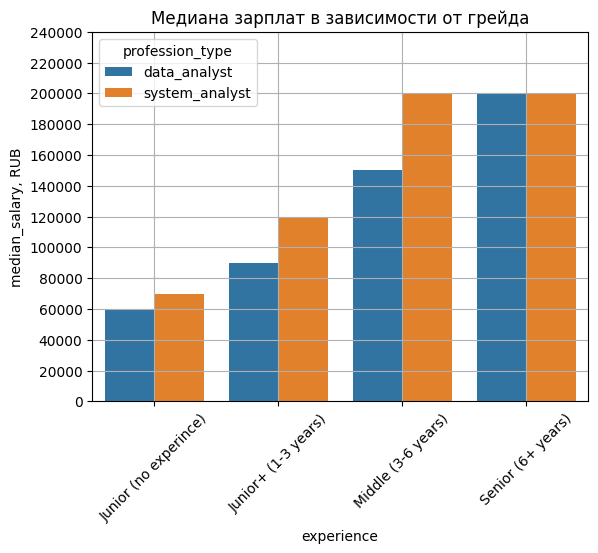

In [27]:
#диаграммa распределения границ зарплат по грейдам
sns.barplot(data = data_salary, x = 'experience', y = 'median_salary_from', hue = 'profession_type')
plt.title('Медиана зарплат в зависимости от грейда')
plt.ylabel('median_salary, RUB')
plt.yticks(np.arange(0, 250000, step=20000))
plt.xticks(rotation=45)
plt.grid()
plt.show()

<div style="border:solid green 1px; padding: 10px">
Вывод:

- данные по зарплате редко публикуются для обоих типов вакансий
- в среднем дата-аналитикам предлагают меньше зарплату, чем сисетмным аналитикам на всех грейдах
- зарплата в прямой зависимости от грейда (чем выше грейд, тем больше зарплата)
- большая разница зарплат между грейдами : разница между junior и senior-специалистами  более чем 3 раза
- следует отметить, что уровень зарплат может сильно отличаться по регионам 

<a id="cell4"></a> 
## Общий вывод:


<div style="border:solid green 1px; padding: 10px">
    
В рамках исследования проанализированы данные по вакансиям из API HH.ru за первое полугодие 2024г:
1. Выгружены данные, выполнена их предобработка (проверка/обработка/исправление пропусков, дубликатов, форматов данных), объединение данных по типам вакансий в один датасет 
2. Проведен исследовательский анализ, по результатам которого можно сделать следующие выводы:

Навыки:
В описаниях вакансий  большую часть требований (более 85%) составляют hard навыки, т.о. специальности дата и системного аналитика требуют больше технических компетенций, чем soft навыков, особенно на начальных и средних позициях.
Нard-навыки почти одинаковы для всех грейдов. Наиболее востребованные hard-навыки для дата аналитиков:  sql, python, pandas, анализ данных, документация. Наиболее востребованные hard-навыки для системных аналитиков:  документация, bpmn, sql, confluence, системный анализ.	
Soft-навыки идентичны для обоих типов специальностей (дата и системный аналитик) и также  идентичны для всех грейдов. Наиболее востребованные soft-навыки: аналитическое мышление, работа с большим объемом информации, коммуникация.

Опыт работы:
Наиболее востребованы специалисты c опытом работы: уровня Junior+(с опытом 1-3 года) и Middle. При этом  у дата-аналитиков более востребованы специалисты Junior+, а у системных аналитиков более востребованы специалисты Middle.  Начинающим дата-аналитикам будет проще найти вакансию.
Специалисты без опыта мало востребованы на рынке труда (6% всех размещенных вакансий). Вакансии для специалистов без опыта (в т.ч. стажировки) в основном размещают специализированные ИТ-компании и крупные технологические компании (бигтех). Следует отметить очень низкое предложение вакансий обоих типов для Senior специалистов (1.5% всех размещенных вакансий). Возможно, это связано с тем, что  HH.ru  - площадка, более ориентированная на специалистов массовых сегментов, а Senior специалисты используют другие, более узко специализированные площадки. 

Формат работы:
Для обоих типов вакансий на всех грейдах лидирует формат - полный день. Почти 17% вакансий дата-аналитиков предлагают удаленную работу, у системных аналитиков удаленная работа более распространена - 34% всех вакансий, что обусловлено спецификой работы.
Почти все вакансии предполагают полную занятость. У некоторых компаний есть варианты стажировок. Безусловным лидером по количеству вакансий-стажировок является Aston (российская ИТ-компания). В основном стажировки предлагают специализированные ИТ-компании и бигтех.

Регионы:
Москва с существенным отрывом лидирует по числу размещенных вакансий обоих типов (почти 65% всех размещенных вакансий), на втором месте - СПб (примерно 10% всех вакансий), в ТОП-5 также входят другие города-миллионники (Екатеринбург, Новосибирск, Казань, Н.Новгород), на эти 4 города в совокупности приходится порядка 9% вакансий.

Работодатели 
ТОП-15 работодателей это компании  следующих отраслей: банки, IT, маркетплейсы, ритейл, коммуникации. Лидером по количеству размещенных вакансий обоих типов (дата-аналитик и системный аналитик) является Сбер. В целом на банковский сектор  приходится примерно 17% размещаемых вакансий*

Зарплата
 : Данные по зарплате редко публикуются для обоих типов вакансий. Зарплата зависит от грейда и очень диверсифицирована между грейдами : разница между junior и senior-специалистами более чем 3 раза. Следует отметить, что уровень зарплат может сильно отличаться по регионам.



